Prédiction du Score avec tous le traitement des données

Chargement des données...

Fusion et structuration des données...

Feature Engineering...

Nettoyage et Anti-Leakage...

Données divisées: Train=(15105, 16), Test=(3777, 16)

Application du Target Encoding...

Encodage One-Hot et MultiLabel...
Dimensions finales matrice X : (15105, 122)

INSPECTION DE LA MATRICE D'ENTRAÎNEMENT (X_train)
Dimensions : (15105, 122) (Lignes, Colonnes)

--- Aperçu des 5 premières lignes ---
       episodes    year  n_staff  n_characters  n_voice_actors  source_age  \
13151       3.0  2001.0     27.0           4.0             4.0           0   
20762      22.0  2013.0     84.0          27.0            64.0           0   
6388        2.0  2000.0      1.0           0.0             0.0           0   
4171        1.0  2016.0      1.0           0.0             0.0           0   
17580      24.0  2011.0     55.0          85.0           154.0           0   

       studio_avg_score  director_avg_score  voice_actor_avg  song_avg  \
13151          6.611491           

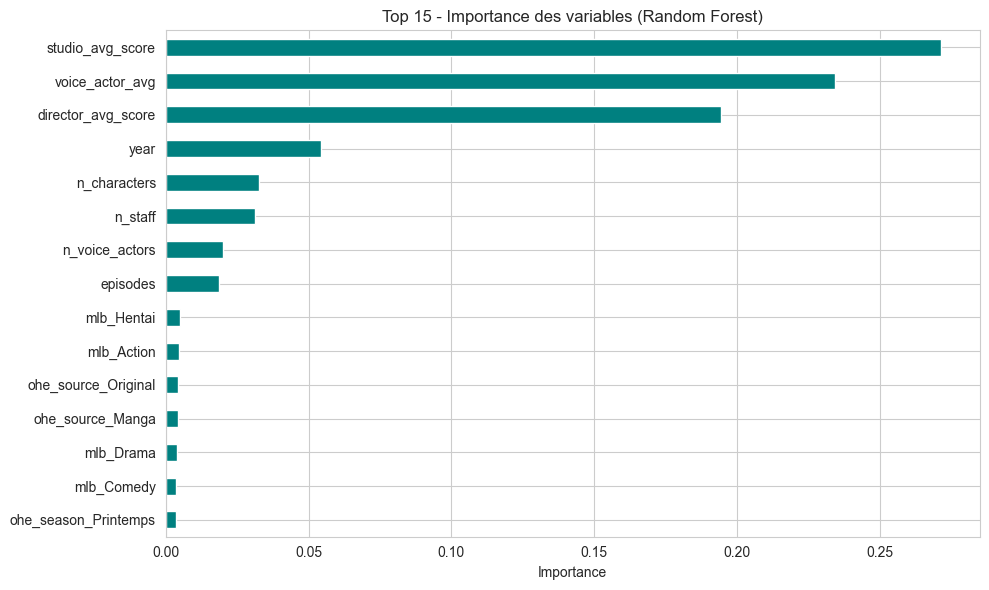

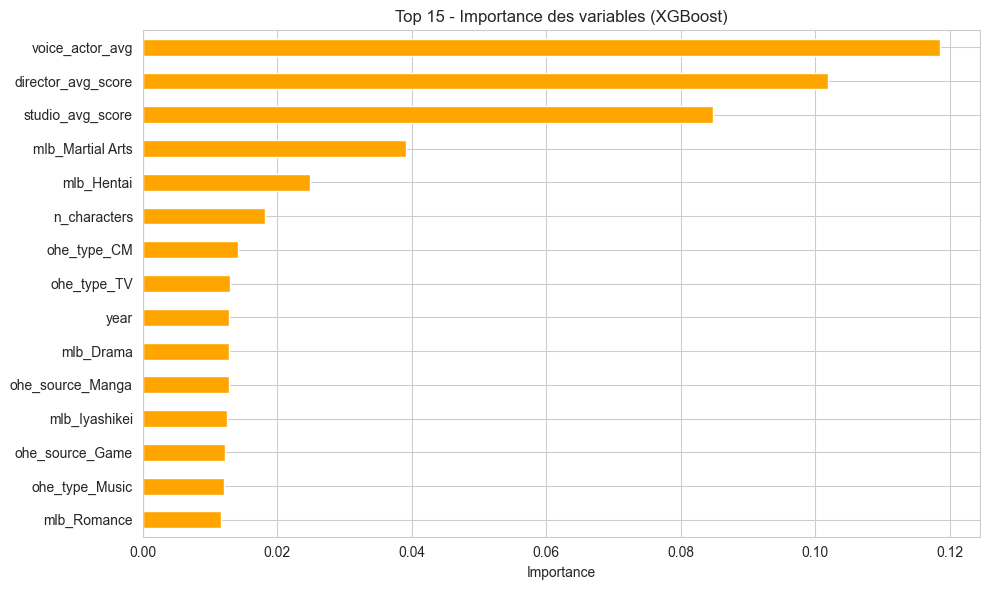


Génération des graphiques...


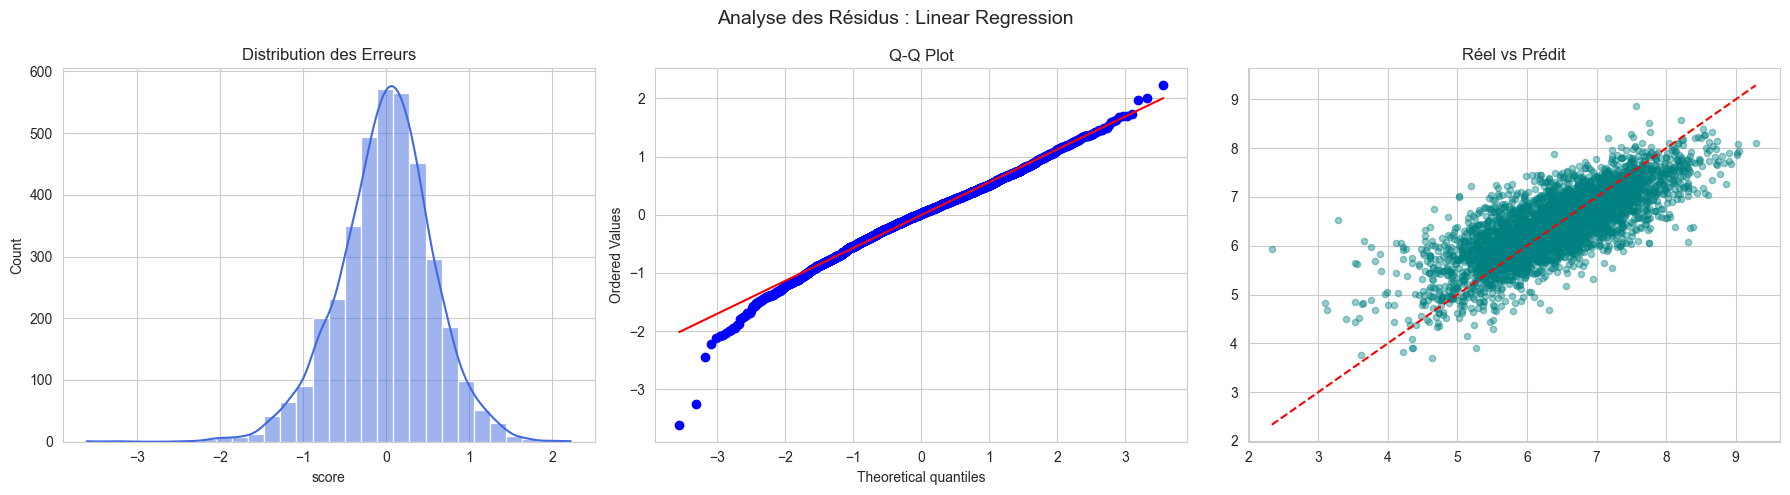

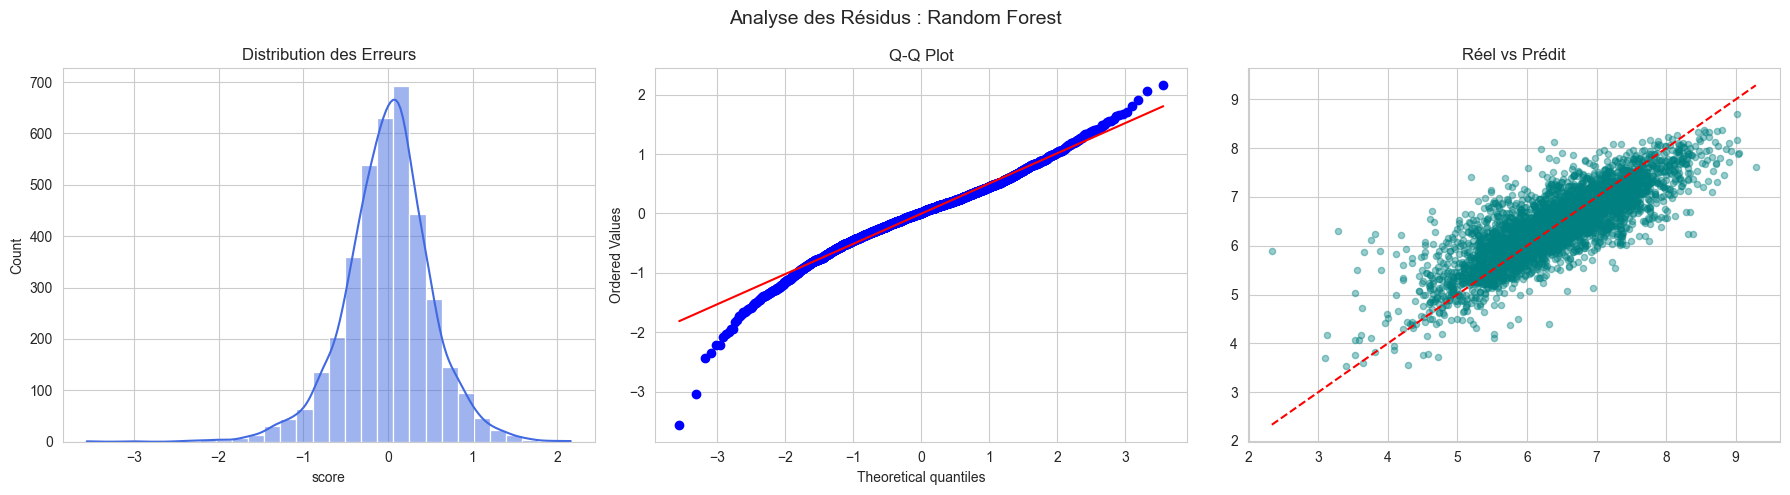

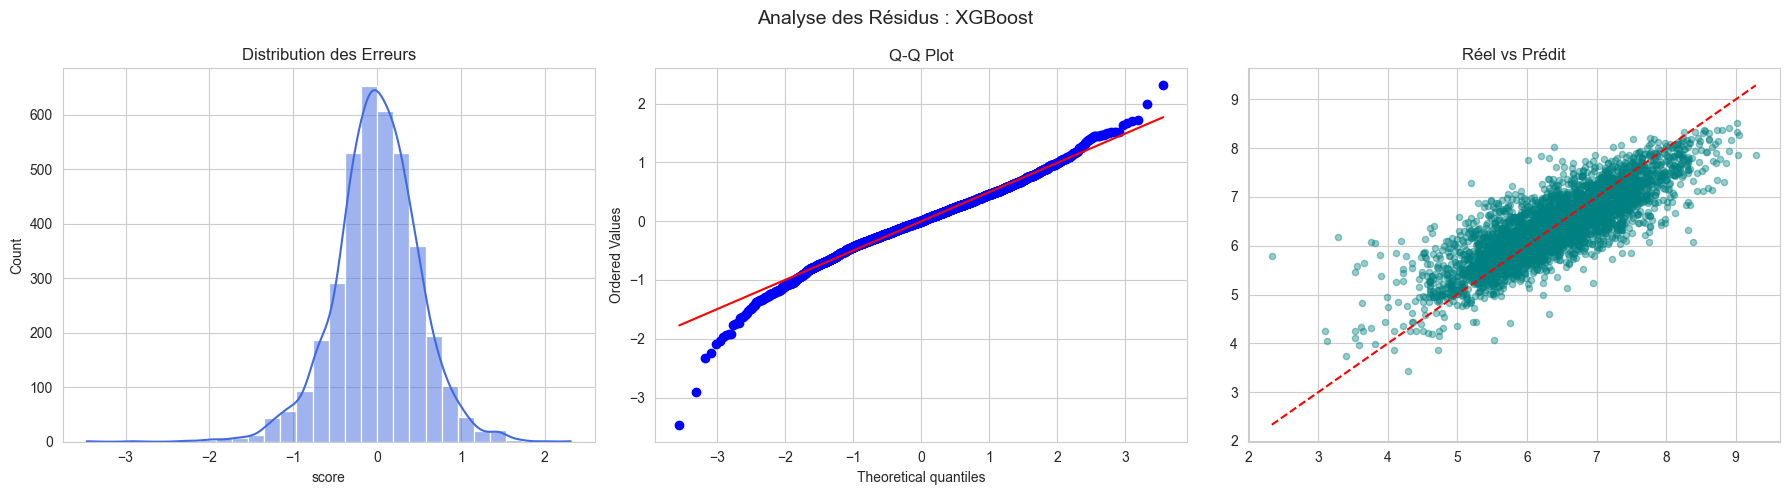

In [3]:
import pandas as pd
import numpy as np
import ast
import re
import warnings
# Modélisation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors # Pour la recommandation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
# Visualisation
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# 1. FONCTIONS UTILITAIRES

def robust_safe_parse_list(x):
    """Parse les listes stockées sous forme de string dans le CSV."""
    if pd.isna(x) or x == '[]' or x == '': return []
    try:
        data = ast.literal_eval(x)
        if isinstance(data, list):
            # Cas des colonnes contenant des dictionnaires
            if data and isinstance(data[0], dict) and 'name' in data[0]:
                return [item['name'] for item in data if 'name' in item]
            # Cas des listes simples
            else: return data
        return []
    except (ValueError, SyntaxError): return []
def get_season(date):
    """Détermine la saisonnalité."""
    if not isinstance(date, pd.Timestamp): return 'Unknown'
    month = date.month
    if month in [12, 1, 2]: return 'Hiver'
    if month in [3, 4, 5]: return 'Printemps'
    if month in [6, 7, 8]: return 'Été'
    if month in [9, 10, 11]: return 'Automne'
    return 'Unknown'
def get_avg_reputation(items_list, mapping, global_avg):
    """Target Encoding pour listes."""
    if not isinstance(items_list, list) or len(items_list) == 0:
        return global_avg
    scores = [mapping.get(item, global_avg) for item in items_list]
    return np.mean(scores)

# 2. CHARGEMENT DES DONNÉES

print("Chargement des données...")
details = pd.read_csv("details.csv")
stats_df = pd.read_csv("stats.csv")
staff = pd.read_csv("person_anime_works.csv")
characters = pd.read_csv("character_anime_works.csv")
voice_works = pd.read_csv("person_voice_works.csv")


# 3. FUSION ET PRÉPARATION INITIALE

print("\nFusion et structuration des données...")
# A. Calculs de comptage
staff_count = staff.groupby('anime_mal_id').size().reset_index(name='n_staff')
char_count = characters.groupby('anime_mal_id').size().reset_index(name='n_characters')
va_count = voice_works.groupby('anime_mal_id').size().reset_index(name='n_voice_actors')
# B. Identification Staff (Target Encoding)
staff['position_lower'] = staff['position'].str.lower()
directors = staff[staff['position_lower'].str.contains('director', na=False)]
director_map = directors.groupby('anime_mal_id')['person_mal_id'].apply(list).to_dict()
voice_actor_map = voice_works.groupby('anime_mal_id')['person_mal_id'].apply(list).to_dict()
# C. Fusion principale
df = details.merge(stats_df, on='mal_id', how='left')
df = df.merge(staff_count, left_on='mal_id', right_on='anime_mal_id', how='left')
df = df.merge(char_count, left_on='mal_id', right_on='anime_mal_id', how='left')
df = df.merge(va_count, left_on='mal_id', right_on='anime_mal_id', how='left')
df.drop(columns=[col for col in df.columns if 'anime_mal_id' in str(col)], inplace=True, errors='ignore')
# Mapping IDs
df['directors_ids'] = df['mal_id'].map(director_map).apply(lambda x: x if isinstance(x, list) else [])
df['voice_actors_ids'] = df['mal_id'].map(voice_actor_map).apply(lambda x: x if isinstance(x, list) else [])

# 4. FEATURE ENGINEERING 

print("\nFeature Engineering...")
# A. Dates
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['year'] = df['start_date'].dt.year
df['season'] = df['start_date'].apply(get_season)
# B. Age source
if 'source' in df.columns:
    df['source_age'] = df.apply(lambda row: row['year'] - int(re.search(r'(\d{4})', row['source']).group(1))
                                if isinstance(row['source'], str) and re.search(r'(\d{4})', row['source']) else 0, axis=1)
    df['source_age'] = df['source_age'].apply(lambda x: max(0, x))
else:
    df['source_age'] = 0
# C. Parsing listes
for col in ['genres', 'themes', 'studios', 'demographics']:
    if col in df.columns:
        df[f'{col}_list'] = df[col].apply(robust_safe_parse_list)
    else:
        df[f'{col}_list'] = [[] for _ in range(len(df))]
# D. Parsing Musique
def extract_songs(row):
    songs = []
    # Liste des noms possibles pour les colonnes musique
    possible_cols = ['opening_themes', 'ending_themes', 'opening_theme', 'ending_theme', 'theme_songs']
   
    for col in possible_cols:
        if col in row.index: # On vérifie si la colonne existe pour cette ligne
            parsed = robust_safe_parse_list(row[col])
            if isinstance(parsed, list):
                songs.extend(parsed)
    return songs
df['songs_list'] = df.apply(extract_songs, axis=1)
# E. Remplissage numérique
cols_numeric = ['episodes', 'year', 'n_staff', 'n_characters', 'n_voice_actors', 'source_age']
for col in cols_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    else:
        df[col] = 0

# 5. NETTOYAGE ET ANTI-LEAKAGE

print("\nNettoyage et Anti-Leakage...")
df = df.dropna(subset=['score'])
df = df[df['score'] > 0]
df_reco = df.copy()
y = df['score']
leakage_cols = [
    'popularity', 'members', 'favorites', 'watching', 'completed',
    'on_hold', 'dropped', 'plan_to_watch', 'total', 'scored_by', 'rank'
] + [f'score_{i}_{t}' for i in range(1, 11) for t in ['votes', 'percentage']]
df_clean = df.drop(columns=[col for col in leakage_cols if col in df.columns], errors='ignore')
cols_to_keep = [
    'episodes', 'year', 'n_staff', 'n_characters', 'n_voice_actors', 'source_age',
    'type', 'source', 'season',
    'directors_ids', 'voice_actors_ids', 'songs_list',
    'genres_list', 'themes_list', 'studios_list', 'demographics_list'
]
X = df_clean[[col for col in cols_to_keep if col in df_clean.columns]].copy()

# 6. SPLIT TRAIN / TEST

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nDonnées divisées: Train={X_train.shape}, Test={X_test.shape}")

# 7. TARGET ENCODING

print("\nApplication du Target Encoding...")
global_mean = y_train.mean()
train_data_encoding = X_train.copy()
train_data_encoding['target_score'] = y_train
encoding_targets = {
    'studios_list': 'studio_avg_score',
    'directors_ids': 'director_avg_score',
    'voice_actors_ids': 'voice_actor_avg',
    'songs_list': 'song_avg'
}

saved_mappers = {}
for col_source, col_final in encoding_targets.items():
    if col_source not in X_train.columns: continue
       
    exploded = train_data_encoding.explode(col_source)
    map_scores = exploded.groupby(col_source)['target_score'].mean().to_dict()
    saved_mappers[col_source] = map_scores # Sauvegarde
   
    X_train[col_final] = X_train[col_source].apply(lambda x: get_avg_reputation(x, map_scores, global_mean))
    X_test[col_final] = X_test[col_source].apply(lambda x: get_avg_reputation(x, map_scores, global_mean))
   
    X_train.drop(columns=[col_source], inplace=True)
    X_test.drop(columns=[col_source], inplace=True)

# 8. ENCODAGE BINAIRE ET MULTILABEL

print("\nEncodage One-Hot et MultiLabel...")
# One-Hot
categorical_cols = ['type', 'source', 'season']
for col in categorical_cols:
    if col in X_train.columns:
        dummies_train = pd.get_dummies(X_train[col], prefix=f'ohe_{col}', dummy_na=True)
        dummies_test = pd.get_dummies(X_test[col], prefix=f'ohe_{col}', dummy_na=True)
       
        X_train = pd.concat([X_train, dummies_train], axis=1).drop(col, axis=1)
        X_test = pd.concat([X_test, dummies_test], axis=1).drop(col, axis=1)
# MultiLabel
multilabel_cols = ['genres_list', 'themes_list', 'demographics_list']
for col in multilabel_cols:
    if col in X_train.columns:
        mlb = MultiLabelBinarizer()
        mlb.fit(X_train[col])
       
        train_enc = pd.DataFrame(mlb.transform(X_train[col]), columns=[f"mlb_{c}" for c in mlb.classes_], index=X_train.index)
        test_enc = pd.DataFrame(mlb.transform(X_test[col]), columns=[f"mlb_{c}" for c in mlb.classes_], index=X_test.index)
       
        X_train = pd.concat([X_train, train_enc], axis=1).drop(col, axis=1)
        X_test = pd.concat([X_test, test_enc], axis=1).drop(col, axis=1)
# Alignement colonnes
train_cols = X_train.columns
for c in set(train_cols) - set(X_test.columns): X_test[c] = 0
for c in set(X_test.columns) - set(train_cols): X_train[c] = 0
X_test = X_test[train_cols]
print(f"Dimensions finales matrice X : {X_train.shape}")


# INSPECTION DE LA MATRICE X 

print("\n" + "="*40)
print("INSPECTION DE LA MATRICE D'ENTRAÎNEMENT (X_train)")
print("="*40)
# 1. Afficher les dimensions
print(f"Dimensions : {X_train.shape} (Lignes, Colonnes)")
# 2. Afficher les 5 premières lignes, pour voir à quoi ça ressemble
print("\n--- Aperçu des 5 premières lignes ---")
print(X_train.head())
# 3. Afficher la liste des colonnes générées
print("\n--- Liste des colonnes (Features) ---")
print(list(X_train.columns))
print("\n--- Détail de la première ligne ---")
first_row = X_train.iloc[0]
# On affiche seulement les colonnes qui ne sont pas à 0 pour y voir clair
print(first_row[first_row != 0])

# 9. MODÉLISATION (AVEC LASSO / ELASTICNET / XGBOOST)

print("\nScaling et Entraînement des modèles...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.005),
    "ElasticNet": ElasticNet(alpha=0.005, l1_ratio=0.5),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1) 
}

results_summary = []
for name, model in models.items():
    print(f"-> Entraînement : {name}")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
   
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
   
    results_summary.append({"Modèle": name, "RMSE": rmse, "MAE": mae, "R²": r2})

# 10. RÉSULTATS COMPARATIFS

print("\n" + "="*60)
print(f"{'Modèle':<20} | {'RMSE':<10} | {'MAE':<10} | {'R²':<10}")
print("-" * 60)
for res in results_summary:
    print(f"{res['Modèle']:<20} | {res['RMSE']:.4f}     | {res['MAE']:.4f}     | {res['R²']:.4f}")
print("="*60)

# Vérification Dummy
dummy_rmse = np.std(y_test)
best_model_rmse = min(r['RMSE'] for r in results_summary)
print(f"\n--- VERIFICATION DE PERTINENCE ---")
print(f"Écart-type naturel (Dummy Model) : {dummy_rmse:.4f}")
print(f"Meilleur RMSE (Modèle)           : {best_model_rmse:.4f}")
print(f"Gain de précision                : {(dummy_rmse - best_model_rmse):.4f} points")

# 11. ANALYSE GRAPHIQUE

sns.set_style("whitegrid")

# --- Focus Importances (Random Forest ET XGBoost) ---
# On boucle sur les modèles qui possèdent l'attribut feature_importances_
models_with_importance = ["Random Forest", "XGBoost"]

for model_name in models_with_importance:
    if model_name in models:
        model = models[model_name]
        # Récupération des importances
        importances = pd.Series(model.feature_importances_, index=X_train.columns)
        
        plt.figure(figsize=(10, 6))
        # Choix de couleur différent pour XGBoost pour distinguer
        color = 'orange' if model_name == "XGBoost" else 'teal'
        
        importances.nlargest(15).sort_values().plot(kind='barh', color=color)
        plt.title(f'Top 15 - Importance des variables ({model_name})')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

# --- Focus Résidus ---
def plot_regression_analysis(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Analyse des Résidus : {model_name}", fontsize=14)
   
    # Histogramme
    sns.histplot(residuals, bins=30, kde=True, ax=axs[0], color='royalblue')
    axs[0].set_title("Distribution des Erreurs")
   
    # QQ Plot
    stats.probplot(residuals, dist="norm", plot=axs[1])
    axs[1].set_title("Q-Q Plot")
   
    # Réel vs Prédit
    axs[2].scatter(y_test, y_pred, alpha=0.4, c='teal', s=20)
    axs[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axs[2].set_title("Réel vs Prédit")
    plt.tight_layout()
    plt.show()

print("\nGénération des graphiques...")
# Ajout de XGBoost dans la liste des modèles à afficher
models_to_plot = ["Linear Regression", "Random Forest", "XGBoost"] 

for name, model in models.items():
    if name in models_to_plot: 
        plot_regression_analysis(model, X_test_scaled, y_test, name)

Prédiction de la Popularité avec traitement des données

In [4]:
import pandas as pd
import numpy as np
import ast
import re
from datetime import datetime
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import scipy.stats as stats # Ici, 'stats' est bien la librairie

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# 1. FONCTIONS UTILITAIRES

def robust_safe_parse_list(x):
    if pd.isna(x) or x == '[]': return []
    try:
        data = ast.literal_eval(x)
        if isinstance(data, list):
            if data and isinstance(data[0], dict) and 'name' in data[0]:
                return [item['name'] for item in data if 'name' in item]
            else: return data
        return []
    except (ValueError, SyntaxError): return []

def get_season(date):
    if not isinstance(date, pd.Timestamp): return 'Unknown'
    month = date.month
    if month in [12, 1, 2]: return 'Hiver'
    if month in [3, 4, 5]: return 'Printemps'
    if month in [6, 7, 8]: return 'Été'
    if month in [9, 10, 11]: return 'Automne'
    return 'Unknown'

def plot_residuals(model, X_test_scaled, y_test, model_name="Model"):
    print(f"\n--- Analyse des résidus pour : {model_name} ---")
    y_pred = model.predict(X_test_scaled)
    residuals = y_test - y_pred
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Analyse des résidus – {model_name}", fontsize=16)
    
    axs[0].hist(residuals, bins=30, color='royalblue', edgecolor='black')
    axs[0].set_title("Histogramme des résidus")
    axs[0].set_xlabel("Erreur (Résidu)")
    axs[0].set_ylabel("Fréquence")
    
    # Cette ligne fonctionnera maintenant car 'stats' est la librairie
    stats.probplot(residuals, dist='norm', plot=axs[1])
    axs[1].set_title("QQ-Plot vs. Distribution Normale")
    
    axs[2].scatter(y_pred, residuals, alpha=0.4, edgecolors='w', s=50)
    axs[2].axhline(0, color='red', linestyle='--')
    axs[2].set_xlabel("Valeurs Prédites")
    axs[2].set_ylabel("Résidus")
    axs[2].set_title("Résidus vs Prédictions")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    mse = mean_squared_error(y_test, y_pred)
    print(f"-> {model_name} | Mean Squared Error (MSE) : {mse:.4f}")


# 2. CHARGEMENT DES DONNÉES 

print("Chargement des données...")
details = pd.read_csv("details.csv")
stats_df = pd.read_csv("stats.csv")
staff = pd.read_csv("person_anime_works.csv")
voice_actors = pd.read_csv("person_voice_works.csv")
characters = pd.read_csv("character_anime_works.csv")

# 3. FUSION ET PRÉPARATION INITIALE 

print("\nFusion et préparation initiale...")
staff_count = staff.groupby('anime_mal_id').size().reset_index(name='n_staff')#compte le nb de staff par anime
char_count = characters.groupby('anime_mal_id').size().reset_index(name='n_characters')#compte le nombre de personnages par anime
staff['position_lower'] = staff['position'].str.lower()
directors = staff[staff['position_lower'].str.contains('director', na=False)]
director_map = directors.groupby('anime_mal_id')['person_mal_id'].apply(list).to_dict()
va_count = voice_actors.groupby('anime_mal_id')['person_mal_id'].nunique().reset_index(name='n_voice_actors')


df = details.merge(stats_df, on='mal_id', how='left')
df = df.merge(staff_count, left_on='mal_id', right_on='anime_mal_id', how='left')
df = df.merge(char_count, left_on='mal_id', right_on='anime_mal_id', how='left')
df = df.merge(va_count, left_on='mal_id', right_on='anime_mal_id', how='left')
df.drop(columns=[col for col in df.columns if 'anime_mal_id' in str(col)], inplace=True, errors='ignore')
df['directors'] = df['mal_id'].map(director_map).apply(lambda x: x if isinstance(x, list) else [])


# 4 Feature Engineering

print("\nCréation des nouvelles caractéristiques (Feature Engineering)...")
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['year'] = df['start_date'].dt.year
df['season'] = df['start_date'].apply(get_season)
df['source_age'] = df.apply(lambda row: row['year'] - int(re.search(r'(\d{4})', row['source']).group(1)) if isinstance(row['source'], str) and re.search(r'(\d{4})', row['source']) else 0, axis=1)
df['source_age'] = df['source_age'].apply(lambda x: max(0, x))
for col in ['genres', 'themes', 'studios', 'demographics']:
    df[f'{col}_list'] = df[col].apply(robust_safe_parse_list)
for col in ['episodes', 'year', 'n_staff', 'n_characters', 'n_voice_actors', 'source_age']:
    df[col].fillna(0, inplace=True)
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)



# 5. NETTOYAGE FINAL ET ANTI-LEAKAGE POUR LA POPULARITÉ

print("\nNettoyage final et suppression des fuites de données...")

df = df.dropna(subset=['members']) # On supprime les lignes où la cible est manquante
df = df[df['members'] > 0] # Le log(0) n'est pas défini, on garde les animés avec au moins 1 membre
y = np.log1p(df['members'])

leakage_cols = [
    'members', 'popularity', 'rank', # La cible et ses proxies directs
    'watching', 'completed', 'on_hold', 'dropped', 'plan_to_watch', 'total', # Les composantes de la cible
    'scored_by', 'favorites', # Conséquences directes de la popularité
    'score' # Le score est une conséquence de la popularité (besoin de membres pour noter)
] + [f'score_{i}_{t}' for i in range(1, 11) for t in ['votes', 'percentage']] # Les votes sont aussi des fuites

df_clean = df.drop(columns=[col for col in leakage_cols if col in df.columns], errors='ignore')

cols_to_keep = ['episodes', 'year', 'n_staff', 'n_characters', 'n_voice_actors', 'source_age', 'type', 'source', 'season', 'directors', 'genres_list', 'themes_list', 'studios_list', 'demographics_list']
X = df_clean[[col for col in cols_to_keep if col in df_clean.columns]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nDonnées divisées: Train={X_train.shape}, Test={X_test.shape}")



# 7. TARGET ENCODING POUR LA POPULARITÉ ("HYPE")

print("\nApplication du Target Encoding...")
global_mean = y_train.mean()
train_data_for_encoding = X_train.join(y_train)

exploded_directors = train_data_for_encoding.explode('directors')
director_mean_hype = exploded_directors.groupby('directors')['members'].mean().to_dict() 
X_train['director_avg_hype'] = X_train['directors'].apply(lambda lst: np.mean([director_mean_hype.get(d, global_mean) for d in lst]) if lst else global_mean)
X_test['director_avg_hype'] = X_test['directors'].apply(lambda lst: np.mean([director_mean_hype.get(d, global_mean) for d in lst]) if lst else global_mean)

exploded_studios = train_data_for_encoding.explode('studios_list')
studio_mean_hype = exploded_studios.groupby('studios_list')['members'].mean().to_dict() 
X_train['studio_avg_hype'] = X_train['studios_list'].apply(lambda lst: np.mean([studio_mean_hype.get(s, global_mean) for s in lst]) if lst else global_mean)
X_test['studio_avg_hype'] = X_test['studios_list'].apply(lambda lst: np.mean([studio_mean_hype.get(s, global_mean) for s in lst]) if lst else global_mean)

# Étape 1: Nettoyer les données sources et créer la map
# On s'assure de ne pas inclure de 'person_mal_id' manquants
clean_voice_actors = voice_actors.dropna(subset=['person_mal_id'])
va_map = clean_voice_actors.groupby('anime_mal_id')['person_mal_id'].apply(list).to_dict()
# Étape 2: Créer la colonne de listes de manière plus robuste
# On itère sur le résultat du map pour garantir que chaque élément est une liste
mapped_va_train = X_train.index.map(va_map)
X_train['voice_actors_list'] = [l if isinstance(l, list) else [] for l in mapped_va_train]
mapped_va_test = X_test.index.map(va_map)
X_test['voice_actors_list'] = [l if isinstance(l, list) else [] for l in mapped_va_test]
# Étape 3: Préparer les données pour l'analyse (explode)
train_data_for_encoding['voice_actors_list'] = [l if isinstance(l, list) else [] for l in train_data_for_encoding.index.map(va_map)]
exploded_vas = train_data_for_encoding.explode('voice_actors_list').dropna(subset=['voice_actors_list'])
# Étape 4: Calculer la réputation de Hype de chaque acteur
voice_actor_mean_hype = exploded_vas.groupby('voice_actors_list')['members'].mean().to_dict()
# Étape 5: Appliquer la réputation aux jeux de données 
X_train['voice_actor_avg_hype'] = X_train['voice_actors_list'].apply(lambda lst: np.mean([voice_actor_mean_hype.get(va, global_mean) for va in lst]) if lst else global_mean)
X_test['voice_actor_avg_hype'] = X_test['voice_actors_list'].apply(lambda lst: np.mean([voice_actor_mean_hype.get(va, global_mean) for va in lst]) if lst else global_mean)
# Nettoyage
X_train.drop(columns=['voice_actors_list'], inplace=True)
X_test.drop(columns=['voice_actors_list'], inplace=True)

# Étape 1: Isoler et nettoyer les artistes musicaux
music_staff = staff[staff['position'].str.contains('Theme Song|Opening|Ending', na=False, case=False)]
clean_music_staff = music_staff.dropna(subset=['person_mal_id'])
song_map = clean_music_staff.groupby('anime_mal_id')['person_mal_id'].apply(list).to_dict()
# Étape 2: Créer la colonne de listes de manière robuste
mapped_song_train = X_train.index.map(song_map)
X_train['song_artists_list'] = [l if isinstance(l, list) else [] for l in mapped_song_train]
mapped_song_test = X_test.index.map(song_map)
X_test['song_artists_list'] = [l if isinstance(l, list) else [] for l in mapped_song_test]
# Étape 3: Préparer les données pour l'analyse
train_data_for_encoding['song_artists_list'] = [l if isinstance(l, list) else [] for l in train_data_for_encoding.index.map(song_map)]
exploded_songs = train_data_for_encoding.explode('song_artists_list').dropna(subset=['song_artists_list'])
# Étape 4: Calculer la réputation de Hype de chaque artiste
song_artist_mean_hype = exploded_songs.groupby('song_artists_list')['members'].mean().to_dict()
# Étape 5: Appliquer la réputation aux jeux de données
X_train['song_avg_hype'] = X_train['song_artists_list'].apply(lambda lst: np.mean([song_artist_mean_hype.get(artist, global_mean) for artist in lst]) if lst else global_mean)
X_test['song_avg_hype'] = X_test['song_artists_list'].apply(lambda lst: np.mean([song_artist_mean_hype.get(artist, global_mean) for artist in lst]) if lst else global_mean)
# Nettoyage
X_train.drop(columns=['song_artists_list'], inplace=True)
X_test.drop(columns=['song_artists_list'], inplace=True)


# 8. ENCODAGE DES VARIABLES CATÉGORIELLES (BINARISATION)

print("\nEncodage des variables...")
categorical_cols = ['type', 'source', 'season']
for col in categorical_cols:
    if col in X_train.columns:
        dummies = pd.get_dummies(X_train[col], prefix=f'ohe_{col}', dummy_na=True)
        X_train = pd.concat([X_train, dummies], axis=1)
        dummies_test = pd.get_dummies(X_test[col], prefix=f'ohe_{col}', dummy_na=True)
        X_test = pd.concat([X_test, dummies_test], axis=1)
        X_train.drop(col, axis=1, inplace=True)
        X_test.drop(col, axis=1, inplace=True)

multilabel_cols = ['genres_list', 'themes_list', 'demographics_list']
for col in multilabel_cols:
    if col in X_train.columns:
        mlb = MultiLabelBinarizer()
        mlb.fit(X_train[col])
        train_encoded = pd.DataFrame(mlb.transform(X_train[col]), columns=[f"mlb_{c}" for c in mlb.classes_], index=X_train.index)
        X_train = pd.concat([X_train, train_encoded], axis=1)
        test_encoded = pd.DataFrame(mlb.transform(X_test[col]), columns=[f"mlb_{c}" for c in mlb.classes_], index=X_test.index)
        X_test = pd.concat([X_test, test_encoded], axis=1)


# 9. FINALISATION DES DATAFRAMES

cols_to_drop_final = ['directors', 'studios_list'] + multilabel_cols
X_train.drop(columns=[col for col in cols_to_drop_final if col in X_train.columns], inplace=True)
X_test.drop(columns=[col for col in cols_to_drop_final if col in X_test.columns], inplace=True)

train_cols = X_train.columns
test_cols = X_test.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test: X_test[c] = 0
missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train: X_train[c] = 0
X_test = X_test[train_cols]
print(f"\nDimensions finales du DataFrame d'entraînement : {X_train.shape}")

Chargement des données...

Fusion et préparation initiale...

Création des nouvelles caractéristiques (Feature Engineering)...

Nettoyage final et suppression des fuites de données...

Données divisées: Train=(23164, 14), Test=(5791, 14)

Application du Target Encoding...

Encodage des variables...

Dimensions finales du DataFrame d'entraînement : (23164, 122)


--- ÉTAPE 1: PRÉPARATION DES DONNÉES ---
✓ Données préparées pour tous les types de modèles.

--- ÉTAPE 2: ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES ---

Entraînement du modèle : Linear Regression...
✓ Linear Regression entraîné.

Entraînement du modèle : Ridge...
✓ Ridge entraîné.

Entraînement du modèle : Lasso...
✓ Lasso entraîné.

Entraînement du modèle : Random Forest...
✓ Random Forest entraîné.

Entraînement du modèle : KNN...
✓ KNN entraîné.

Entraînement du modèle : ElasticNet...
✓ ElasticNet entraîné (Meilleurs params: {'alpha': 0.001, 'l1_ratio': 0.9}).

Entraînement du modèle : XGBoost...
✓ XGBoost entraîné (Meilleure itération: 992).

Entraînement du modèle : Backward Elimination...
✓ Backward Elimination entraîné (66 variables sélectionnées).

Entraînement du modèle : Forward Selection...
✓ Forward Selection entraîné (66 variables sélectionnées).

Entraînement du modèle : Stepwise Selection...
✓ Stepwise Selection entraîné (66 variables sélectionnées).


--- ÉTAPE 3: COMPARA

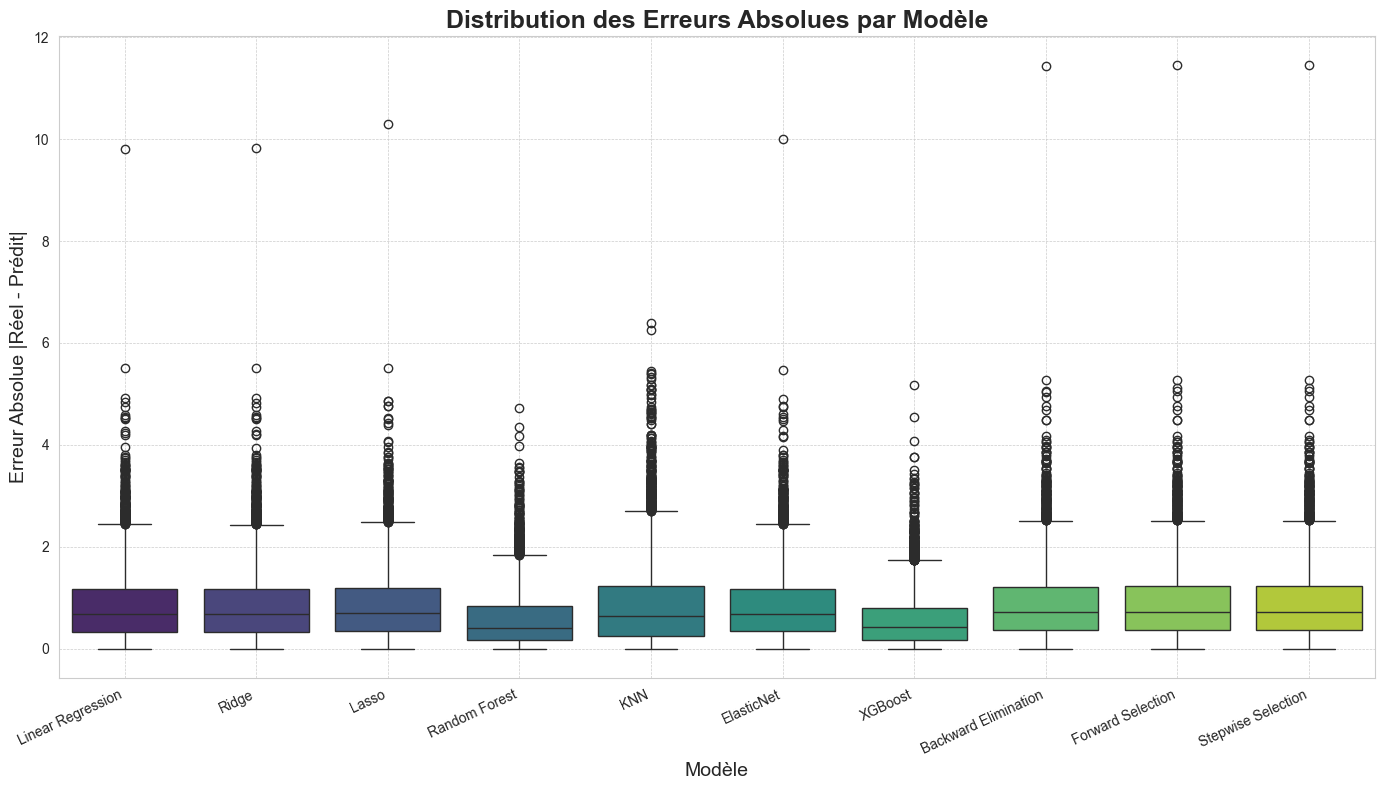

In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- Imports des modèles ---
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import statsmodels.api as sm

# --- Imports des métriques ---
from sklearn.metrics import mean_squared_error, r2_score

# ÉTAPE 1 : PRÉPARATION DES DONNÉES

print("--- ÉTAPE 1: PRÉPARATION DES DONNÉES ---")

# --- 1a. Données mises à l'échelle (pour modèles linéaires et KNN) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 1b. Données pour statsmodels (Backward/Stepwise) ---
def clean_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = re.sub(r'[^A-Za-z0-9_]+', '', col)
        new_cols.append(new_col)
    df.columns = new_cols
    return df

X_train_sm = clean_col_names(X_train.copy().select_dtypes(include=np.number))
X_test_sm = clean_col_names(X_test.copy().select_dtypes(include=np.number))
common_cols = list(set(X_train_sm.columns) & set(X_test_sm.columns))
X_train_sm = X_train_sm[common_cols]
X_test_sm = X_test_sm[common_cols]

print("✓ Données préparées pour tous les types de modèles.")


# ÉTAPE 2 : ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES

print("\n--- ÉTAPE 2: ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES ---")

all_predictions = {}
all_errors = {}

# --- Modèles Scikit-learn Simples (Ridge, Lasso, RF) ---
models_to_run = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

for name, model in models_to_run.items():
    print(f"\nEntraînement du modèle : {name}...")
    if name in ["Linear Regression","Ridge", "Lasso"]:
        model.fit(X_train_scaled, y_train)
        all_predictions[name] = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        all_predictions[name] = model.predict(X_test)
    print(f"✓ {name} entraîné.")

# --- Modèle KNN ---
print("\nEntraînement du modèle : KNN...")
knn = KNeighborsRegressor(n_neighbors=9)
knn.fit(X_train_scaled, y_train)
all_predictions["KNN"] = knn.predict(X_test_scaled)
print("✓ KNN entraîné.")

# --- Modèle ElasticNet ---
print("\nEntraînement du modèle : ElasticNet...")
elastic_net_grid = GridSearchCV(
    ElasticNet(random_state=42, max_iter=10000),
    param_grid={'alpha': [0.001, 0.01, 0.1], 'l1_ratio': [0.1, 0.5, 0.9]},
    cv=3, scoring='neg_mean_squared_error', n_jobs=-1
)
elastic_net_grid.fit(X_train_scaled, y_train)
all_predictions["ElasticNet"] = elastic_net_grid.predict(X_test_scaled)
print(f"✓ ElasticNet entraîné (Meilleurs params: {elastic_net_grid.best_params_}).")

# --- Modèle XGBoost ---
print("\nEntraînement du modèle : XGBoost...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000,
                             learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1,
                             early_stopping_rounds=20, eval_metric='rmse')
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
all_predictions["XGBoost"] = xgb_model.predict(X_test)
print(f"✓ XGBoost entraîné (Meilleure itération: {xgb_model.best_iteration}).")

# --- Modèle Backward Elimination ---
print("\nEntraînement du modèle : Backward Elimination...")
def backward_elimination(x, y, sl=0.05):
    features = list(x.columns)
    while len(features) > 0:
        model = sm.OLS(y, sm.add_constant(x[features])).fit()
        p_values = model.pvalues[1:]
        if p_values.max() > sl: features.remove(p_values.idxmax())
        else: break
    final_model = sm.OLS(y, sm.add_constant(x[features])).fit()
    return features, final_model

backward_features, backward_model = backward_elimination(X_train_sm, y_train)
X_test_backward = sm.add_constant(X_test_sm[backward_features])
all_predictions["Backward Elimination"] = backward_model.predict(X_test_backward)
print(f"✓ Backward Elimination entraîné ({len(backward_features)} variables sélectionnées).")

# --- Modèle Forward Selection ---
print("\nEntraînement du modèle : Forward Selection...")
def forward_selection(x, y, sl=0.05):
    initial_features = list(x.columns)
    best_features = []
    while True:
        remaining_features = list(set(initial_features) - set(best_features))
        new_p_values = pd.Series(index=remaining_features, dtype='float64')
        for new_feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(x[best_features + [new_feature]])).fit()
            new_p_values[new_feature] = model.pvalues[new_feature]
        min_p_value = new_p_values.min()
        if min_p_value < sl:
            best_feature = new_p_values.idxmin()
            best_features.append(best_feature)
        else:
            break
    final_model = sm.OLS(y, sm.add_constant(x[best_features])).fit()
    return best_features, final_model

forward_features, forward_model = forward_selection(X_train_sm, y_train)
X_test_forward = sm.add_constant(X_test_sm[forward_features])
all_predictions["Forward Selection"] = forward_model.predict(X_test_forward)
print(f"✓ Forward Selection entraîné ({len(forward_features)} variables sélectionnées).")

# --- Modèle Stepwise Selection ---
print("\nEntraînement du modèle : Stepwise Selection...")
def stepwise_selection(x, y, sl_in=0.05, sl_out=0.05):
    initial_features = list(x.columns)
    best_features = []
    while True:
        changed = False
        # Forward step
        remaining_features = list(set(initial_features) - set(best_features))
        new_p_values = pd.Series(index=remaining_features, dtype='float64')
        for new_feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(x[best_features + [new_feature]])).fit()
            new_p_values[new_feature] = model.pvalues[new_feature]
        min_p_value = new_p_values.min()
        if min_p_value < sl_in:
            best_feature = new_p_values.idxmin()
            best_features.append(best_feature)
            changed = True
        
        # Backward step
        if len(best_features) > 0:
            model = sm.OLS(y, sm.add_constant(x[best_features])).fit()
            p_values = model.pvalues.iloc[1:]
            max_p_value = p_values.max()
            if max_p_value > sl_out:
                worst_feature = p_values.idxmax()
                best_features.remove(worst_feature)
                changed = True
            
        if not changed:
            break
    final_model = sm.OLS(y, sm.add_constant(x[best_features])).fit()
    return best_features, final_model

stepwise_features, stepwise_model = stepwise_selection(X_train_sm, y_train)
X_test_stepwise = sm.add_constant(X_test_sm[stepwise_features])
all_predictions["Stepwise Selection"] = stepwise_model.predict(X_test_stepwise)
print(f"✓ Stepwise Selection entraîné ({len(stepwise_features)} variables sélectionnées).")


# ÉTAPE 3 : RÉSULTATS ET GRAPHIQUES COMPARATIFS 

print("\n\n--- ÉTAPE 3: COMPARAISON FINALE DES MODÈLES ---")

# --- 3a. Tableau Récapitulatif ---
results_summary = []
for name, y_pred in all_predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results_summary.append({"Modèle": name, "RMSE": rmse, "R²": r2})
    all_errors[name] = np.abs(y_test - y_pred)

results_df = pd.DataFrame(results_summary).sort_values(by="RMSE", ascending=True)

print("\n" + "="*45)
print("       TABLEAU RÉCAPITULATIF DES PERFORMANCES")
print("="*45)
print(results_df.to_string(index=False))
print("="*45)

# --- 3b. Boxplot Comparatif des Erreurs ---
df_errors_all = pd.DataFrame(all_errors)
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_errors_all, orient='v', palette='viridis')
plt.title('Distribution des Erreurs Absolues par Modèle', fontsize=18, fontweight='bold')
plt.ylabel('Erreur Absolue |Réel - Prédit|', fontsize=14)
plt.xlabel('Modèle', fontsize=14)
plt.xticks(rotation=25, ha='right') 
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Systeme de recommendation

In [ ]:
import random
df_reco = df.copy()

# 2. Vérification d'alignement
missing_indices = [idx for idx in X_train.index if idx not in df_reco.index]
if len(missing_indices) > 0:
    print(f"ATTENTION : {len(missing_indices)} indices décalés. Relancez le Split Train/Test si possible.")
else:
    print("✓ Synchronisation des indices OK.")


# 12. PRÉPARATION SPÉCIFIQUE POUR LA RECOMMANDATION

print("\n" + "="*60)
print("MISE EN PLACE DU SYSTÈME DE RECOMMANDATION (FULL XGBOOST)")
print("="*60)

# --- A. Modèle pour le SCORE (Qualité) ---

print("1. Préparation du modèle de Score (XGBoost)...")

if "XGBoost" in models:
    # Si le modèle a déjà été entraîné à l'étape 9
    xgb_model_score = models["XGBoost"]
    print("-> Modèle Score (XGBoost) récupéré.")
else:
    # Sinon, on l'entraîne maintenant
    xgb_model_score = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
    xgb_model_score.fit(X_train_scaled, y_train)
    print("-> Modèle Score (XGBoost) entraîné à l'instant.")

# --- B. Modèle pour la POPULARITÉ (Nombre de membres) ---
print("2. Entraînement du modèle de Popularité (XGBoost)...")

# Alignement des index pour éviter le KeyError
valid_indices = X_train.index.intersection(df_reco.index)

# Gestion du filtrage si nécessaire
if len(valid_indices) < len(X_train):
    print(f"Ajustement des données Popularité ({len(valid_indices)} lignes)...")
    positions = [X_train.index.get_loc(idx) for idx in valid_indices]
    X_train_scaled_pop = X_train_scaled[positions]
else:
    X_train_scaled_pop = X_train_scaled

# Cible : log(members) pour gérer l'échelle exponentielle
y_pop_train = np.log1p(df_reco.loc[valid_indices, 'members'])

xgb_model_pop = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model_pop.fit(X_train_scaled_pop, y_pop_train)
print("-> Modèle Popularité (XGBoost) entraîné.")

# --- C. KNN (Contenu) ---
print("3. Initialisation du KNN sur les données de test...")
knn = NearestNeighbors(n_neighbors=50, metric='cosine', n_jobs=-1)
knn.fit(X_test_scaled)



# 13. DÉFINITION DES FONCTIONS DE RECOMMANDATION



def get_recommendations_final(title, weights, k=5):
    # 1. Retrouver l'ID
    try:
        found = df_reco[df_reco['title'] == title]
        if found.empty:
            print(f"Erreur : '{title}' non trouvé.")
            return
        idx = found.index[0]
    except IndexError:
        return

    # 2. Vérifier présence dans X_test 
    if idx not in X_test.index:
        print(f"Le film '{title}' n'est pas dans le set de Test. Impossible de trouver ses voisins KNN.")
        return

    print(f"\nFilm source : {title}")
    print(f"Poids (Sim={weights[0]}, Pop={weights[1]}, Qual={weights[2]})")
    print("-" * 95)
    print(f"{'Titre Recommandé':<50} | {'Score Global':<10} | {'Sim':<6} | {'Pop(Pred)':<10} | {'Note(Pred)':<10}")
    print("-" * 95)

    pos = X_test.index.get_loc(idx)
    vec = X_test_scaled[pos].reshape(1, -1)
    dists, inds = knn.kneighbors(vec, n_neighbors=20)
    
    w_sim, w_pop, w_qual = weights
    candidates = []

    for i in range(1, len(dists[0])):
        neighbor_pos = inds[0][i]
        if neighbor_pos >= len(X_test): continue
        n_idx = X_test.index[neighbor_pos]
        if n_idx not in df_reco.index: continue

        n_title = df_reco.loc[n_idx, 'title']
        feat_scaled = X_test_scaled[neighbor_pos].reshape(1, -1)
        
        p_pop_log = xgb_model_pop.predict(feat_scaled)[0]
        p_score = xgb_model_score.predict(feat_scaled)[0] 
        
        # Normalisation
        s_sim = 1 / (1 + dists[0][i])
        s_pop = min(max(p_pop_log, 0) / 16.0, 1.0)
        s_qual = min(max(p_score, 0), 10.0) / 10.0
        
        final_score = (w_sim * s_sim) + (w_pop * s_pop) + (w_qual * s_qual)
        
        candidates.append({
            'title': n_title,
            'score': final_score,
            'sim': s_sim,
            'pop_raw': np.expm1(p_pop_log),
            'qual': p_score
        })

    for c in sorted(candidates, key=lambda x: x['score'], reverse=True)[:k]:
        print(f"{c['title'][:48]:<50} | {c['score']:.4f}     | {c['sim']:.2f}   | {int(c['pop_raw']):<10} | {c['qual']:.2f}")
    print("-" * 95)

def evaluate_weights_strategy(sample_size=30):
    print("\nOptimisation des poids...")
    weight_combinations = [(0.8, 0.1, 0.1), (0.5, 0.3, 0.2), (0.3, 0.5, 0.2), (0.2, 0.2, 0.6)]
    
    # Validation : on ne garde que les indices valides
    valid_indices = [i for i in X_test.index if i in df_reco.index 
                     and isinstance(df_reco.loc[i, 'genres_list'], list) 
                     and len(df_reco.loc[i, 'genres_list']) > 0]
    
    if not valid_indices:
        print("Aucun index valide trouvé pour l'évaluation.")
        return (0.5, 0.3, 0.2)

    sample_indices = random.sample(valid_indices, min(sample_size, len(valid_indices)))
    results = []

    for w_sim, w_pop, w_qual in weight_combinations:
        total_matching_score = 0
        for idx in sample_indices:
            pos = X_test.index.get_loc(idx)
            vec = X_test_scaled[pos].reshape(1, -1)
            dists, inds = knn.kneighbors(vec, n_neighbors=10)
            
            candidates = []
            for i in range(1, len(dists[0])):
                n_pos = inds[0][i]
                if n_pos >= len(X_test): continue
                n_idx = X_test.index[n_pos]
                if n_idx not in df_reco.index: continue
                
                feat = X_test_scaled[n_pos].reshape(1, -1)

                p_pop = xgb_model_pop.predict(feat)[0]
                p_score = xgb_model_score.predict(feat)[0] 
                
                s_sim = 1 / (1 + dists[0][i])
                s_pop = min(max(p_pop, 0) / 16.0, 1.0)
                s_qual = min(max(p_score, 0), 10.0) / 10.0
                
                final = (w_sim * s_sim) + (w_pop * s_pop) + (w_qual * s_qual)
                candidates.append((n_idx, final))
            
            top_3 = sorted(candidates, key=lambda x: x[1], reverse=True)[:3]
            if top_3:
                source_genres = set(df_reco.loc[idx, 'genres_list'])
                avg_jaccard = 0
                for n_idx, _ in top_3:
                    rec_genres = set(df_reco.loc[n_idx, 'genres_list'])
                    u = len(source_genres | rec_genres)
                    if u > 0: avg_jaccard += len(source_genres & rec_genres) / u
                total_matching_score += (avg_jaccard / len(top_3))
        
        results.append({'Weights': (w_sim, w_pop, w_qual), 'Coherence': total_matching_score / len(sample_indices)})

    best = sorted(results, key=lambda x: x['Coherence'], reverse=True)[0]
    print(f"CONFIGURATION RETENUE : {best['Weights']} (Score: {best['Coherence']:.4f})")
    return best['Weights']


# 14. EXÉCUTION


best_weights = evaluate_weights_strategy(sample_size=20)

print("\n--- TEST DE RECOMMANDATION ---")
# On essaye de prendre un titre qui existe vraiment pour éviter le test aléatoire vide
possible_ids = X_test.index.intersection(df_reco.index)

if len(possible_ids) > 0:
    try:
        popular_subset = df_reco.loc[possible_ids].sort_values('members', ascending=False).head(100)
        random_idx = random.choice(popular_subset.index)
    except:
        random_idx = random.choice(possible_ids)
        
    random_title = df_reco.loc[random_idx, 'title']
    get_recommendations_final(random_title, weights=best_weights)
else:
    print("Erreur critique : Aucune correspondance entre X_test et les données.")

✓ Synchronisation des indices OK.

MISE EN PLACE DU SYSTÈME DE RECOMMANDATION (FULL XGBOOST)
1. Préparation du modèle de Score (XGBoost)...
-> Modèle Score (XGBoost) récupéré.
2. Entraînement du modèle de Popularité (XGBoost)...
-> Modèle Popularité (XGBoost) entraîné.
3. Initialisation du KNN sur les données de test...

Optimisation des poids...
CONFIGURATION RETENUE : (0.8, 0.1, 0.1) (Score: 0.6750)

--- TEST DE RECOMMANDATION ---

Film source : Kokoro Connect
Poids (Sim=0.8, Pop=0.1, Qual=0.1)
-----------------------------------------------------------------------------------------------
Titre Recommandé                                   | Score Global | Sim    | Pop(Pred)  | Note(Pred)
-----------------------------------------------------------------------------------------------
Toradora!                                          | 0.9087     | 0.94   | 726126     | 6.96
Just Because!                                      | 0.8782     | 0.90   | 338776     | 8.22
True Tears         